In [1]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
from EasyOptim import (
    EasyPartition, 
    EasyIteration, 
    register_data,
    register_current_data
)
from datetime import datetime

## Simulate phase conjugation optimization experiment
### Parameters of the system

In [2]:
n_in = 200
n_out = 100

### Generate transmission matrix represented by a random Gaussian complex matrix

In [3]:
H = np.random.randn(n_out,n_in)+1j*np.random.randn(n_out,n_in)

### Define the parameter to optimize: the energy at a target point

In [4]:
def snr_on_target(i_target, phases):
    E_in = np.exp(1j*np.array(phases))
    E_out = H@E_in
    I_target = np.abs(E_out[i_target])**2
    #I_mean = np.mean(np.abs(E_out)**2)
    data = {'E_out':E_out}
    # return two objects:
    # - the value to optimize
    # - a dictionnary that will be saved, 
    #   the data corresponding to the best state will be returned by the algorithm
    return I_target, data

i_target = n_out//2
cost = lambda x: snr_on_target(i_target, x)

## Sequential algorithm

### Initialize the algorithm

In [5]:
myalgo = EasyIteration(
    n_var = n_in,
    min_or_max = 'max',
    n_repeat = 2)


### Give the cost function to the algorithm object

In [6]:
myalgo.register_callback(cost)

### Run the algorithm

It returns three objects:
* the best value found for the cost function,
* the corresponding input vector,
* a dictionnary of saved data (see the second example to populate this dicitonnary).

Moreover:
* the evolution of the cost function can be accessed after optimization calling 
the `myalgo.evol` list,
* the data (`E_out` here) for each iteration is stored in the list of dictionnaries
`myalgo.evol_data`.

In [7]:
phase_values = np.linspace(0,2*np.pi,10, endpoint = False)
best_value, phase_in_opt, data = myalgo.run(
    values = phase_values,
    x_init = None)

Repeat: 1/2 | Iter: 200/200 | Cost = 65149.4931: 100%|██████████| 200/200 [00:00<00:00, 328.90it/s]
Repeat: 2/2 | Iter: 200/200 | Cost = 65206.2953: 100%|██████████| 200/200 [00:00<00:00, 414.95it/s]


### Analalyze the results

**Compute output intensity for the optimize input field found**

In [8]:
E_in_opt = np.exp(1j*np.array(phase_in_opt))
E_out_opt = H@E_in_opt
I_out_opt = np.abs(E_out_opt)**2
I_out_opt /= np.mean(I_out_opt)

**Compute output intensity for the ideal phase conjugation**

In [9]:
# Ideal phase conjugation
E_in_cp = H[i_target,:].conjugate()
E_out_cp = H@E_in_cp
I_out_cp = np.abs(E_out_cp)**2
I_out_cp /= np.mean(I_out_cp)

Text(0.5, 1.0, 'Evolution of the target value')

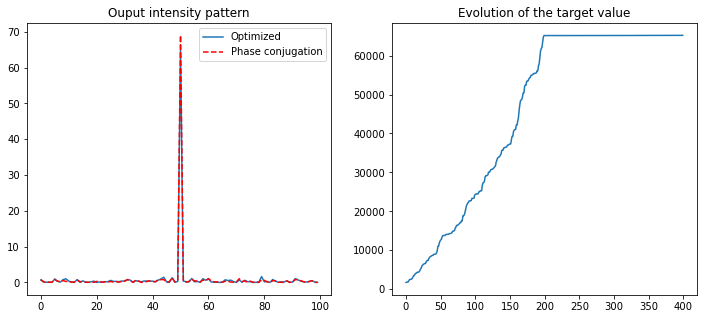

In [10]:
plt.figure(figsize = (12,5))
plt.subplot(121)
plt.plot(I_out_opt, label = 'Optimized')
plt.plot(I_out_cp, 'r--', label = 'Phase conjugation')
plt.title('Ouput intensity pattern')
plt.legend()
plt.subplot(122)
plt.plot(myalgo.evol)
plt.title('Evolution of the target value')

**We can recover data we registered for any iteration**

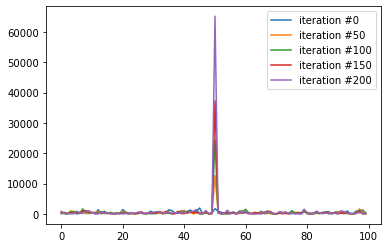

In [11]:
indices = np.linspace(0, myalgo.n_var, 5, dtype = int)

plt.figure()
for i in indices:
    I_out = np.abs(myalgo.evol_data[i]['E_out'])**2 
    plt.plot(I_out, label = f'iteration #{i}')
plt.legend()

## Partition Algorithm

We will use here the callback functions that are called as specific times to log relevant data.

Requiest Neptune.ai for this example:

`conda install -c conda-forge neptune-client`

or

`pip install neptune-client`

In [12]:
import neptune

### Initialize a logger
Not compulsory, but it is a good practice and a good example of the use the callback functions.

We use Neptune.ai here, with the public account. Create your account to save privately your logs.

In [13]:
!conda  list | grep neptune

neptune-client            0.13.0             pyhd8ed1ab_0    conda-forge
neptune-contrib           0.27.1                   pypi_0    pypi


In [14]:
neptune.init(
    api_token="ANONYMOUS",
    project_qualified_name = "shared/pytorch-lightning-integration"
)

Project(shared/pytorch-lightning-integration)

In [15]:
now = datetime.now().strftime("%d-%m-%Y %H:%M")
    
# these parameter will be saved by the logger when creating the experiment
params={'method':'partition',
        'start_time':now}

neptune.create_experiment(params = params)

Info (NVML): NVML Shared Library Not Found. GPU usage metrics may not be reported. For more information, see https://docs-legacy.neptune.ai/logging-and-managing-experiment-results/logging-experiment-data.html#hardware-consumption 


https://ui.neptune.ai/shared/pytorch-lightning-integration/e/PYTOR-172962


Experiment(PYTOR-172962)

**The link above gives access to the logs**

### Create a fraction function

It corresponds to the faction of element that will be updated at each iteration. 
The length of the vector give the number of iteration per repeat.

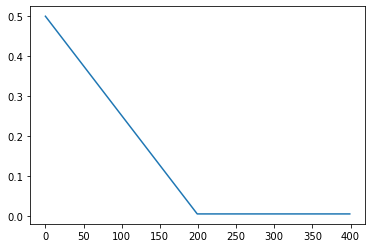

In [16]:
frac_min = 1./n_in
fractions = np.linspace(.5, frac_min, n_in)
fractions = np.concatenate([fractions,np.array([frac_min]*n_in)])
plt.figure()
plt.plot(fractions)

### Create a custom optimization object

We overload the callback functions to log data at different times.

Using the decorator `@EasyOptim.register_data`, the dictionnary returned by the functions updates to the one returned by the algorithm once finished (data is added or replaced if it already exists).

`@EasyOptim.register_current_data` adds the returned dictionnary to the list of dictionnaries returned, one element for each iteration.

In [17]:
plt.ioff() 

class part_algo(EasyPartition):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
      
    @register_data
    def begin(self):
        return {'test_beginning':True,
                'initial_E_in': np.exp(1j*np.array(self.current_x))}
    
    @register_data
    def end(self):
        return {'test_end':42,
                'end_E_in': np.exp(1j*np.array(self.current_x))}
     
    @register_current_data
    def after_iter(self, i_iter, best_cost, best_x, best_data):
        neptune.log_metric('cost_evol',self.best_cost)
        if i_iter % 10 == 0:
            I_out = np.abs(best_data['E_out'])**2
            fig = plt.figure(figsize=(7, 9))
            plt.plot(I_out)
            neptune.log_image('I_out',fig)
            plt.close(fig)
        return {'test_iter':2}

### Initialize the algorithm object

In [18]:
myalgo = part_algo(
        n_var = n_in,
        min_or_max = 'max',
        n_repeat = 1)
myalgo.register_callback(cost)

### Run the algorithm

In [ ]:
phase_values = np.linspace(0,2*np.pi,10, endpoint = False)
best_value, phase_in_opt, data = myalgo.run(
    values = phase_values,
    fractions = fractions,
    x_init = None)

Repeat: 1/1 | Part: 232/400 | Cost = 34297.5302:  58%|█████▊    | 231/400 [00:03<00:02, 72.29it/s]

### Look at the data dictionnary

In [ ]:
print(data.keys())

In [ ]:
plt.figure()
plt.title('Input phase')
plt.plot(np.angle(data['initial_E_in']), label = 'initial guess')
plt.plot(np.angle(data['end_E_in']), label = 'last (not best) iteration')
plt.legend()

### Analalyze the results

In [ ]:
E_in_cp = H[i_target,:].conjugate()
E_out_cp = H@E_in_cp
I_out_cp = np.abs(E_out_cp)**2
I_out_cp /= np.mean(I_out_cp)

E_in_opt = np.exp(1j*np.array(phase_in_opt))
E_out_opt = H@E_in_opt
I_out_opt = np.abs(E_out_opt)**2
I_out_opt /= np.mean(I_out_opt)

In [ ]:
plt.figure(figsize = (12,5))
plt.subplot(121)
plt.plot(I_out_opt, label = 'Optimized')
plt.plot(I_out_cp, 'r--', label = 'Phase conjugation')
plt.title('Ouput intensity pattern')
plt.legend()
plt.subplot(122)
plt.plot(myalgo.evol)
plt.title('Evolution of the target value')

In [ ]:
indices = np.linspace(0, myalgo.n_var, 5, dtype = int)

plt.figure()
for i in indices:
    I_out = np.abs(myalgo.evol_data[i]['E_out'])**2 
    plt.plot(I_out, label = f'iteration #{i}')
plt.legend()